# Superimpose data

The aim of this notebook is to indicate how to superimpose data from different sources (radar, satellite, weather models...).

There are 2 data categories :
<ul>
    <li>data projected on a grid (radar, weather models...)</li>
    <li>punctual data like observations from ground stations</li>
</ul>

So, this notebook provides functions which allow to :
<ul>
    <li>superimpose 2 grids of different resolutions</li>
    <li>superimpose data on a grid with punctual data</li>
</ul>

# I - Superimpose 2 grids of different resolutions

## I.1 - 2 GRIB files 
### Example : 3D ARPEGE data on isobaric levels (0.1°) to interpolate to 2D AROME data on the 2m level (0.025°)
#### Use xarray to open GRIB files and perform interpolation

In [1]:
from data_exploration.utils.user_configuration import *
import xarray as xr
import datetime as dt
%matplotlib notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import colors
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

In [2]:
####Cell containing the modifiable fields######
zone = "SE"     #geographic zone (NW or SE)
arp_param = 't'    #arpege : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
aro_param = 't2m' #arome : parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
date = dt.datetime(2018, 5, 1,0,0) # Day example 
time_step = 0                #index for the studied time step 
level_step = 0               #index for the studied level step (from ground upwards)

arp_fname = "../data_sample/weather_models/arpege_3D_isobar_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))
aro_fname = "../data_sample/weather_models/arome_2m_%s_%s.grib" % (zone,date.strftime('%Y%m%d%H%M%S'))

In [112]:
#/!\#### the plots options depend on the GRIB file structure (for example, 'isobaricInhPa =' means we have a 3D grib file with isobaric levels)
def grib_interpolate_grib(ori_fname,tar_fname,time_step,level_step,ori_param,tar_param):
    
    #data loading
    data_to_interpolate = xr.open_dataset(ori_fname, engine='cfgrib')  
    target_data = xr.open_dataset(tar_fname, engine='cfgrib')  
    
    #today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
    interpolated_data = data_to_interpolate.interp_like(target_data,method='linear')
    
    #plots
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 2, figure = fig)
    #data to interpolate
    ax =  pl.subplot(gs[0, 0])
    p1 =  data_to_interpolate.isel(step=time_step, isobaricInhPa = level_step)[ori_param].plot(x="longitude",y="latitude")
    plt.title('original data')

    #interpolated data
    ax =  pl.subplot(gs[0, 1])
    p1 = interpolated_data.isel(step=time_step, isobaricInhPa = level_step)[ori_param].plot(x="longitude",y="latitude")
    plt.title('interpolated data')

    #destination data 
    ax =  pl.subplot(gs[1, 0])
    p1 = target_data.isel(step=time_step)[tar_param].plot(x="longitude",y="latitude")
    plt.title('data on target grid')
    
    return data_to_interpolate,interpolated_data, target_data

<IPython.core.display.Javascript object>


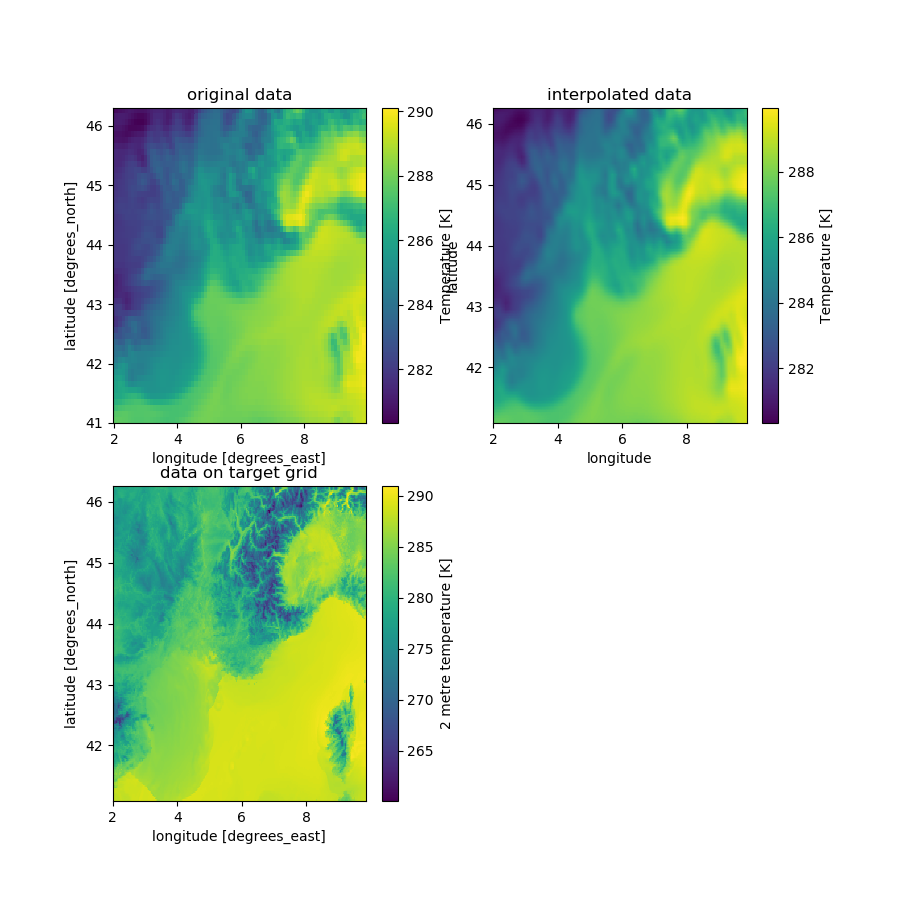

In [113]:
#data to interpolate : ARPEGE, target data : AROME
data_to_interpolate,interpolated_data, target_data = grib_interpolate_grib(arp_fname,aro_fname,time_step,level_step,arp_param,aro_param)

## I.2 - 1 GRIB file and 1 radar file
### Example : rainfall data (NPZ file, 0.01°) to interpolate to land-sea mask (GRIB file, 0.025°)

In [116]:
####Cell containing the modifiable fields######
year = 2016
month = 8
decade = 3
ind = 15   #index of the chosen 5 min of the decade 
nan_value = -1  #nan value for data (ex : rainfall here)

rain_param = 'rainfall'    #parameter name for rainfall
mask_param = 'lsm'         #parameter name for land-sea mask (cf meta-data in the mask GRIB file)

rain_fname = "../data_sample/radar/rainfall_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
rain_coords_fname = "../data_sample/radar/radar_coords_%s.npz" % (zone)
mask_fname = "../data_sample/masks/%s_masks.grib" % (zone)

#### Step 1 : put NPZ data into an xarray (values, lat, lon)

In [117]:
def radar_to_grib(rain_fname,rain_coords_fname,ind):
    
    #load data
    d = np.load(rain_fname, allow_pickle=True)
    data = d['data'][ind,:,:]
    
    coords = np.load(rain_coords_fname, allow_pickle=True)
    lat = coords['lats']
    lon = coords['lons']
    
    data = xr.DataArray(data,coords=[lat[:,0],lon[0,:]],dims=['latitude','longitude'])
    d_grib = data.to_dataset(name = 'rainfall')
    
    return d_grib,lat,lon

In [118]:
d_grib,lat,lon = radar_to_grib(rain_fname,rain_coords_fname,ind)

In [119]:
np.unique(d_grib['rainfall'].values)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  77,  78,
        79,  80,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  95,  97,  98, 101, 103, 106, 107, 108, 109, 110, 111, 112,
       115, 116, 118, 122, 123, 124, 125, 129, 133, 136, 137, 138, 139,
       142, 144, 145, 152, 153, 154, 157, 160, 162, 163, 164, 168, 169,
       171, 172, 174, 178, 181, 184, 187, 191, 196, 200, 202], dtype=int16)

#### Step 2 : perform the interpolation
**/!\ if the 'missing data' value is not nan (for example it is -1 for rainfall), it is necessary to convert these values before into nan if you want to use the linear interpolation method, else use the nearest neighbors method**

In [120]:
#/!\#### the plots options depend on the GRIB file structure###
def radar_interpolate_grib(ori_data,tar_fname,ori_param,tar_param,nan_value):
    
    #data loading
    data_to_interpolate = ori_data
    nan_data_to_interpolate = data_to_interpolate.where(data_to_interpolate["rainfall"]!=nan_value)  #missing data (from value to 'nan')
    target_data = xr.open_dataset(tar_fname, engine='cfgrib')  
    
    #today, with the function above, 2 interpolation methods are implemented for 2D arrays : 'linear' and 'nearest' for nearest neighbors
    interpolated_data = nan_data_to_interpolate.interp_like(target_data,method='linear')
    
    #plots
    fig = plt.figure(figsize=(9,9))
    gs = gridspec.GridSpec(2, 2, figure = fig)
        
    #colorbar definition for rainfall
    if (np.max(data_to_interpolate[ori_param].values) > 65):
        borne_max = np.max(data_to_interpolate[ori_param].values)
    else:
        borne_max = 65 + 10
    cmap = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 'skyblue','olive','mediumseagreen'
                                  ,'cyan','lime','yellow','khaki','burlywood','orange','brown','pink','red','plum'])
    bounds = [-1,0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,borne_max]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    #data to interpolate without nan (original data)
    ax =  pl.subplot(gs[0, 0])    
    data_to_interpolate[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('original data - missing data  : -1')
    
    #data to interpolate with nan
    ax =  pl.subplot(gs[0, 1])    
    nan_data_to_interpolate[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('original data with nan - missing data : ' + str(nan_value))

    #interpolated data
    ax =  pl.subplot(gs[1, 0])
    interpolated_data[ori_param].plot(cmap=cmap, norm=norm) 
    plt.title('interpolated data - missing data : nan')

    #destination data 
    ax =  pl.subplot(gs[1, 1]) 
    target_data[tar_param].plot()
    plt.title('data on target grid')
    
    return data_to_interpolate,nan_data_to_interpolate,interpolated_data, target_data

<IPython.core.display.Javascript object>


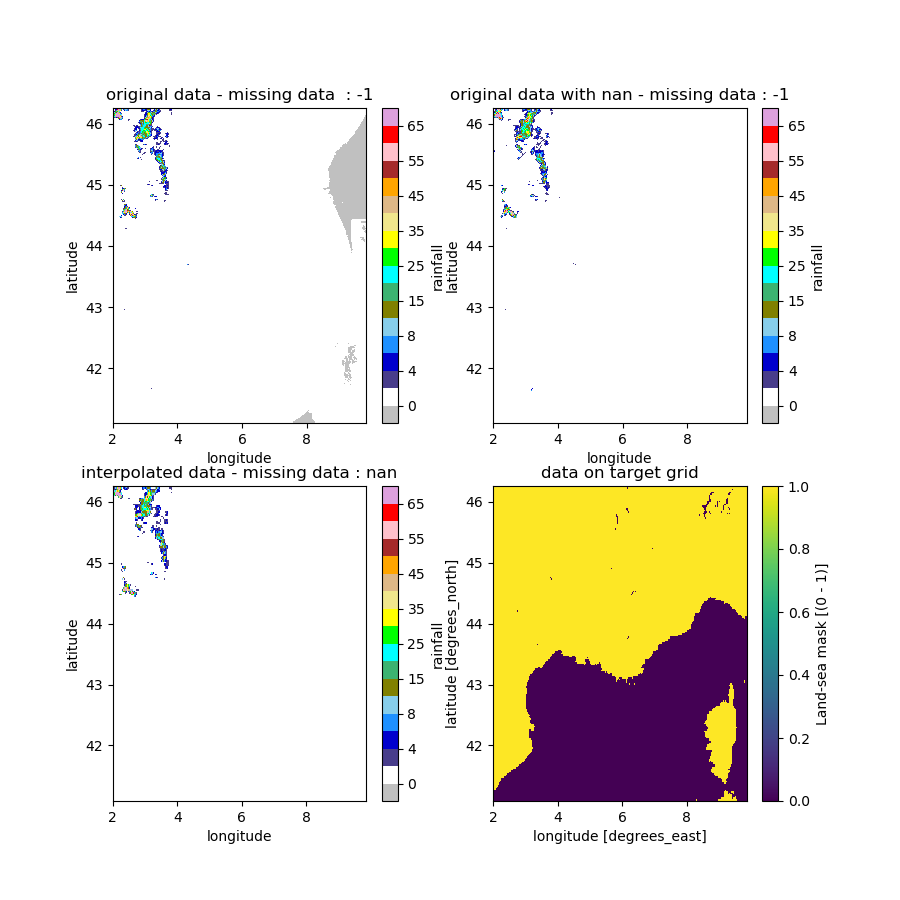

In [121]:
data_to_interpolate,nan_data_to_interpolate,interpolated_data, target_data = radar_interpolate_grib(d_grib,mask_fname,rain_param,mask_param,nan_value)

# II - Superimpose data on a grid with punctual data

### Example 1 : 2D AROME data on the 2m level (GRIB file, 0.025°) to interpolate to ground station observations

In [28]:
####Cell containing the modifiable fields######
date = '2016-01-01T06:00:00'    #study date 
obs_param = 't'      #observation parameter
grib_param = 't2m'   #AROME parameter

In [126]:
study_date = pd.Timestamp(date)  #study date
fname = "../data_sample/ground_stations/%s_20160101.csv"%zone
df =pd.read_csv(fname,parse_dates=[4],infer_datetime_format=True)
d_sub = df[df['date'] == study_date]

Overview of observation data for a given date :

In [127]:
display(d_sub.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
28830,1027003,45.83,5.11,196.0,2016-01-01 06:00:00,NaN,NaN,NaN,99.0,276.45,276.55,NaN
28831,1033002,46.09,5.81,350.0,2016-01-01 06:00:00,360.0,0.5,0.0,99.0,276.25,276.35,NaN
28832,1034004,45.77,5.69,330.0,2016-01-01 06:00:00,360.0,1.2,0.0,100.0,277.15,277.15,NaN
28833,1072001,46.20,5.29,260.0,2016-01-01 06:00:00,NaN,NaN,0.0,NaN,NaN,272.95,NaN
28834,1089001,45.98,5.33,252.0,2016-01-01 06:00:00,40.0,1.2,0.0,97.0,276.75,277.15,102700.0


Load AROME data : parameter values, latitudes and longitudes

In [128]:
aro = xr.open_dataset(aro_fname, engine='cfgrib')
grid_lat = aro['latitude'].values
grid_lon = aro['longitude'].values
grid_val = aro[grib_param].values

Perform the interpolation

In [129]:
def interpolate_grib_on_points(grid_lat,grid_lon,grid_val,data_obs):
    
    #initialisation
    latlon_grid = []
    latlon_obs = []
    val_grid = []
    
    #grid data preprocessing
    for i in range(0,grid_lat.shape[0]):        
        for j in range(0,grid_lon.shape[0]):
            #put coordinates (lat,lon) in list of tuples
            latlon_grid.append([round(grid_lat[i],3),round(grid_lon[j],3)])
            #put grid values into a list
            val_grid.append(grid_val[time_step,i,j])
    grid_latlon = np.array(latlon_grid)
    grid_val2 = np.array(val_grid)

    #obs data preprocessing : put coordinates (lat,lon) in list of tuples
    for i in range(0,data_obs.shape[0]):
        latlon_obs.append([data_obs['lat'].values[i],data_obs['lon'].values[i]])
    latlon_obs = np.array(latlon_obs)
    
    #interpolation
    grid_val_on_points=griddata(grid_latlon ,grid_val2, latlon_obs,  method='linear')
    return latlon_obs,grid_val_on_points

In [123]:
latlon_obs,grid_val_on_points = interpolate_grib_on_points(grid_lat,grid_lon,grid_val,d_sub)

latlon_obs : tuples of [lat,lon] of observation points

In [124]:
latlon_obs[0:10]

array([[45.83   ,  5.11   ],
       [46.09   ,  5.81   ],
       [45.77   ,  5.69   ],
       [46.2    ,  5.29   ],
       [45.98   ,  5.33   ],
       [45.9797 ,  5.5982 ],
       [46.09   ,  5.482  ],
       [46.0467 ,  5.07329],
       [45.9503 ,  5.461  ],
       [45.91617,  5.62467]])

grid_val_on_points : array of grid values interpolated on observation points 

In [125]:
grid_val_on_points[0:10]

array([282.56607056, 280.77096558, 282.17345581, 282.15485229,
       281.57816162, 277.99950806, 279.24011963, 281.2622771 ,
       280.32728381, 276.87529873])

### Example 2 : radar data (rainfall, NPZ file, 0.01°) to interpolate to ground station observations

In [36]:
####Cell containing the modifiable fields######
###obs###
date = '2016-01-01T06:00:00'    #study date 
obs_param = 't'      #observation parameter
npz_param = 'rainfall'   #npz parameter

#rainfall##
year = 2016
month = 8
decade = 3
ind = 15   #index of the chosen 5 min of the decade 
nan_value = -1  #nan value for data (ex : rainfall here)

rain_fname = "../data_sample/radar/rainfall_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
rain_coords_fname = "../data_sample/radar/radar_coords_%s.npz" % (zone)

In [37]:
study_date = pd.Timestamp(date)  #study date
fname = "../data_sample/ground_stations/%s_20160101.csv"%zone
df =pd.read_csv(fname,parse_dates=[4],infer_datetime_format=True)
d_sub = df[df['date'] == study_date]

Overview of observation data for a given date :

In [32]:
display(d_sub.head())

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
28830,1027003,45.83,5.11,196.0,2016-01-01 06:00:00,NaN,NaN,NaN,99.0,276.45,276.55,NaN
28831,1033002,46.09,5.81,350.0,2016-01-01 06:00:00,360.0,0.5,0.0,99.0,276.25,276.35,NaN
28832,1034004,45.77,5.69,330.0,2016-01-01 06:00:00,360.0,1.2,0.0,100.0,277.15,277.15,NaN
28833,1072001,46.20,5.29,260.0,2016-01-01 06:00:00,NaN,NaN,0.0,NaN,NaN,272.95,NaN
28834,1089001,45.98,5.33,252.0,2016-01-01 06:00:00,40.0,1.2,0.0,97.0,276.75,277.15,102700.0


Load radar data : parameter values, latitudes and longitudes

In [103]:
radar = np.load(rain_fname, allow_pickle=True)
data = radar['data'][ind,:,:]
coords = np.load(rain_coords_fname, allow_pickle=True)
lat = coords['lats']
lon = coords['lons']

#### Perform the interpolation
**/!\ if the 'missing data' value is not nan (for example it is -1 for rainfall), it is necessary to convert these values before into nan if you want to use the linear interpolation method, else use the nearest neighbors method**

In [134]:
def interpolate_radar_on_points(grid_lat,grid_lon,grid_val,data_obs):
    #grid data preprocessing
    latlon_grid = []
    latlon_obs = []
    val_grid = []
    for i in range(0,grid_lat.shape[0]):        
        for j in range(0,grid_lon.shape[1]):
            #put coordinates (lat,lon) in list of tuples
            latlon_grid.append([grid_lat[i,0],grid_lon[0,j]])
            #put grid values into a list
            val_grid.append(grid_val[i,j])
    grid_latlon = np.array(latlon_grid)
    grid_val2 = np.array(val_grid)
    #replace 'missing data' values by nan
    grid_val2 = grid_val2.astype(np.float64)
    grid_val2[grid_val2==-1]=np.nan

    #obs data preprocessing : put coordinates (lat,lon) in list of tuples
    for i in range(0,data_obs.shape[0]):
        latlon_obs.append([data_obs['lat'].values[i],data_obs['lon'].values[i]])
    latlon_obs = np.array(latlon_obs)

    #interpolation
    grid_val_on_points=griddata(grid_latlon ,grid_val2, latlon_obs,  method='linear')
    return latlon_obs,grid_val_on_points

In [131]:
latlon_obs,grid_val_on_points = interpolate_radar_on_points(lat,lon,data,d_sub)

latlon_obs : tuples of [lat,lon] of observation points

In [132]:
latlon_obs

array([[45.83   ,  5.11   ],
       [46.09   ,  5.81   ],
       [45.77   ,  5.69   ],
       [46.2    ,  5.29   ],
       [45.98   ,  5.33   ],
       [45.9797 ,  5.5982 ],
       [46.09   ,  5.482  ],
       [46.0467 ,  5.07329],
       [45.9503 ,  5.461  ],
       [45.91617,  5.62467],
       [46.17   ,  3.4    ],
       [46.06   ,  3.23   ],
       [46.19   ,  2.96   ],
       [46.05   ,  3.81   ],
       [44.24   ,  6.63   ],
       [44.39   ,  6.67   ],
       [44.06   ,  5.99   ],
       [43.91   ,  5.77   ],
       [44.07   ,  6.18667],
       [44.03   ,  6.62   ],
       [44.39   ,  6.33   ],
       [44.33   ,  6.03   ],
       [43.98   ,  6.52   ],
       [44.22   ,  5.92   ],
       [43.8395 ,  6.00083],
       [44.8    ,  6.73   ],
       [44.57   ,  6.5    ],
       [44.57   ,  5.75   ],
       [44.58   ,  6.08   ],
       [44.32   ,  5.79   ],
       [44.77   ,  6.98   ],
       [44.39   ,  5.46   ],
       [44.7    ,  6.6    ],
       [44.67   ,  6.21   ],
       [44.45 

grid_val_on_points : array of grid values interpolated on observation points 

In [133]:
grid_val_on_points

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  5.   ,  8.   ,  3.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      